<a href="https://colab.research.google.com/github/vokashlob/OTUS/blob/main/OTUS_%22denoising_ae_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Обучить многослойный автокодировщик:
* а. отрисовать классы в латентном представлении автокодировщика с двумерным латентным слоем 
* б. сделать tSNE над 32-мерным латентным слоем, отрисовать представление

2. Обучить шумный автокодировщик: 
* a. Добавить ко входным данным нормальный шум
* б. Сделать отражение части изображения
* в. Отрисовать карты активаций нейронов первого слоя

# Utils - обязательно запускаем вначале. Дальнейшие блоки первого уровня автономны

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train - valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80);
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k: [z for z in zip(*log[k])] for k in keys}
    epochs = {k: range(len(log[k])) for k in keys}

    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

# Многослойный линейный автоэнкодер

## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

## Preprocessing

In [ ]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

## Model (multilayered)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size * 4)
        self.fc2 = nn.Linear(latent_size * 4, latent_size * 2)
        self.fc3 = nn.Linear(latent_size * 2, latent_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, latent_size * 2)
        self.fc2 = nn.Linear(latent_size * 2, latent_size * 4)
        self.fc3 = nn.Linear(latent_size * 4, 28*28)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out

    def encode(self, x):
        with torch.no_grad():
          return self.E(x)
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [ ]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

## add_noise()

In [ ]:
def add_noise(x, mode='crop', elementwise=False):
    # if np.random.randint(2):
    #   return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2) * 2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one

        elif mode == 'mirror':
            for i in range(x.shape[0]):
                img_part = np.random.randint(4)
                dim = np.random.choice([1,2])
                if img_part == 0:
                  x[i, :, :14, :14] = torch.flip(x[i, :, :14, :14], (0,dim))
                elif img_part == 1:
                  x[i, :, :14, 14:] = torch.flip(x[i, :, :14, 14:], (0,dim))
                elif img_part == 2:
                  x[i, :, 14:, :14] = torch.flip(x[i, :, 14:, :14], (0,dim))
                elif img_part == 3:
                  x[i, :, 14:, 14:] = torch.flip(x[i, :, 14:, 14:], (0,dim))

        elif mode == 'gaussian':
            mean = 0.5
            std = 0.5
            x = x + torch.randn(x.size()) * std + mean   

    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2) * 2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x


## train()

In [ ]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

## test()

In [ ]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

## Аугментация данных и визуализация работы функции add_noise() в разных режимах ('crop', 'mirror', 'gaussian')


In [ ]:
data, _ = next(iter(test_loader))
noized_crop = add_noise(data, mode='crop', elementwise=True)
noized_mirror = add_noise(data, mode='mirror', elementwise=True)
noized_gaussian = add_noise(data, mode='gaussian', elementwise=True)
output = models['64'](noized_crop[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

Исходный набор:


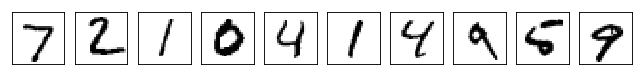

Заплатки:


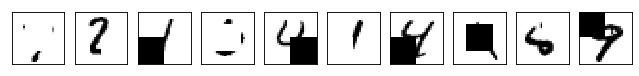

Отражения:


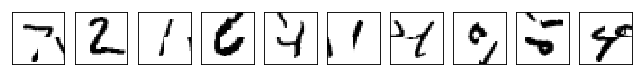

Шум:


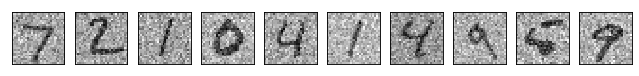

In [ ]:
print("Исходный набор:")
plot_mnist(data.data.numpy()[:10], (1, 10))
print('Заплатки:')
plot_mnist(noized_crop[:10], (1, 10))
print('Отражения:')
plot_mnist(noized_mirror[:10], (1, 10))
print('Шум:')
plot_mnist(noized_gaussian[:10], (1, 10))

## Обучение

In [ ]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 16: 0.949840 32: 0.935832 64: 0.928344
Train Epoch: 1 [30000/60000] 16: 0.890000 32: 0.801194 64: 0.489556
Train Epoch: 1 [60000/60000] 16: 0.771193 32: 0.435343 64: 0.285575
Test set:
16: loss: 0.7549
32: loss: 0.3994
64: loss: 0.2768

Train Epoch: 2 [00000/60000] 16: 0.745888 32: 0.380821 64: 0.274164
Train Epoch: 2 [30000/60000] 16: 0.530150 32: 0.294500 64: 0.272003
Train Epoch: 2 [60000/60000] 16: 0.365324 32: 0.274993 64: 0.263653
Test set:
16: loss: 0.3618
32: loss: 0.2772
64: loss: 0.2715

Train Epoch: 3 [00000/60000] 16: 0.347300 32: 0.271311 64: 0.271138
Train Epoch: 3 [30000/60000] 16: 0.311824 32: 0.281390 64: 0.275027
Train Epoch: 3 [60000/60000] 16: 0.293295 32: 0.281222 64: 0.272441
Test set:
16: loss: 0.2818
32: loss: 0.2737
64: loss: 0.2654

Train Epoch: 4 [00000/60000] 16: 0.278504 32: 0.268208 64: 0.258076
Train Epoch: 4 [30000/60000] 16: 0.283178 32: 0.279883 64: 0.260473
Train Epoch: 4 [60000/60000] 16: 0.284981 32: 0.283559 64: 0.26368

### Визуализация результатов обучения

In [ ]:
data, _ = next(iter(test_loader))
noized_crop = add_noise(data, mode='crop', elementwise=True)
noized_mirror = add_noise(data, mode='mirror', elementwise=True)
noized_gausiian = add_noise(data, mode='gaussian', elementwise=True)
output = models['64'](noized_mirror[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

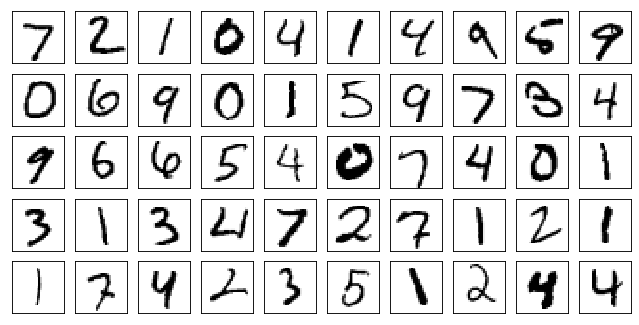

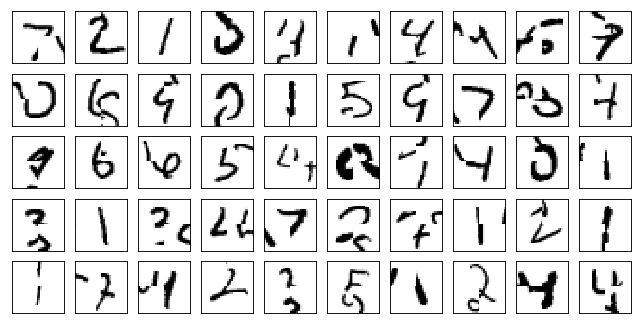

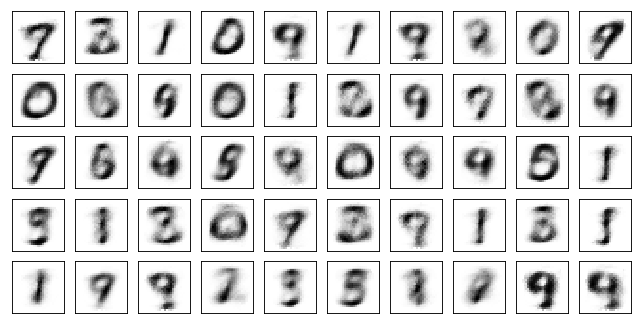

In [ ]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized_mirror[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

# Отрисовываем двумерный латентный слой

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

## Preprocessing

In [ ]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

## переписываем модель, включив encoder и decoder в единый класс (мне так удобнее :))

In [ ]:
class AE(nn.Module):
  def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
        nn.Linear(28*28, 64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Linear(16, 2)
        )
        self.decoder = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, 28*28),
        nn.Tanh()    
        )

  def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

  def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = F.mse_loss(x, target, **kwargs)
        return self._loss

## train()

In [ ]:
def train(model, num_epochs=5, learning_rate=0.0001, l2=0.):
    # torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=l2)
    # outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = model.loss(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    #     outputs.append((epoch, img, recon),)
    # return outputs

## Training

In [ ]:
model = AE()
max_epochs = 100
train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.2792
Epoch:2, Loss:0.2570
Epoch:3, Loss:0.2500
Epoch:4, Loss:0.2300
Epoch:5, Loss:0.2313
Epoch:6, Loss:0.2137
Epoch:7, Loss:0.2208
Epoch:8, Loss:0.2194
Epoch:9, Loss:0.2202
Epoch:10, Loss:0.2159
Epoch:11, Loss:0.2110
Epoch:12, Loss:0.2144
Epoch:13, Loss:0.2131
Epoch:14, Loss:0.2043
Epoch:15, Loss:0.2081
Epoch:16, Loss:0.1971
Epoch:17, Loss:0.2020
Epoch:18, Loss:0.2041
Epoch:19, Loss:0.1999
Epoch:20, Loss:0.1953
Epoch:21, Loss:0.2020
Epoch:22, Loss:0.1991
Epoch:23, Loss:0.1879
Epoch:24, Loss:0.1917
Epoch:25, Loss:0.1896
Epoch:26, Loss:0.1954
Epoch:27, Loss:0.1906
Epoch:28, Loss:0.1876
Epoch:29, Loss:0.1909
Epoch:30, Loss:0.1798
Epoch:31, Loss:0.1876
Epoch:32, Loss:0.1844
Epoch:33, Loss:0.1866
Epoch:34, Loss:0.1948
Epoch:35, Loss:0.1840
Epoch:36, Loss:0.1830
Epoch:37, Loss:0.1888
Epoch:38, Loss:0.1811
Epoch:39, Loss:0.1761
Epoch:40, Loss:0.1840
Epoch:41, Loss:0.1785
Epoch:42, Loss:0.1863
Epoch:43, Loss:0.1896
Epoch:44, Loss:0.1833
Epoch:45, Loss:0.1806
Epoch:46, Loss:0.18

## визуализация

In [ ]:
images, labels = next(iter(train_loader))
print(images.size())
print(labels.size())

torch.Size([200, 1, 28, 28])
torch.Size([200])


In [ ]:
images = images.view(-1, 28*28)
enc = model.encoder(images)

In [ ]:
enc.size()

torch.Size([200, 2])

In [ ]:
enc = enc.detach().numpy()

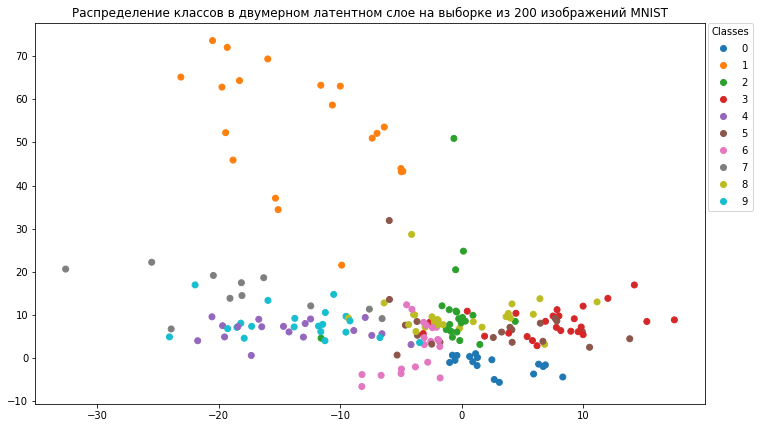

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
scatter = ax.scatter(enc[:, 0], enc[:, 1], c=labels.numpy(), cmap='tab10')
ax.legend(*scatter.legend_elements(), loc='upper right', title="Classes", bbox_to_anchor=(1.08, 1.015));
plt.title(f'Распределение классов в двумерном латентном слое на выборке из {enc.shape[0]} изображений MNIST');

Здесь понятно, что должно получиться в идеале - более-менее кучные кластеры по каждому из классов. Но поскольку сеть обучена так себе, то с кластерами тоже не очень сложилось. 

# tSNE

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np
from sklearn.manifold import TSNE

%matplotlib inline

## Preprocessing

In [ ]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model

In [ ]:
class AE_32(nn.Module):
  def __init__(self):
        super(AE_32, self).__init__()
        self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Tanh()    
        )

  def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

  def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = F.mse_loss(x, target, **kwargs)
        return self._loss

## train()

In [ ]:
def train(model, num_epochs=5, learning_rate=0.001, l2=0.):
    # torch.manual_seed(42)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=l2)
    # outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = model.loss(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    #     outputs.append((epoch, img, recon),)
    # return outputs

## training

In [ ]:
model = AE_32()
max_epochs = 20
train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.1263
Epoch:2, Loss:0.0890
Epoch:3, Loss:0.0791
Epoch:4, Loss:0.0719
Epoch:5, Loss:0.0661
Epoch:6, Loss:0.0598
Epoch:7, Loss:0.0531
Epoch:8, Loss:0.0495
Epoch:9, Loss:0.0493
Epoch:10, Loss:0.0464
Epoch:11, Loss:0.0484
Epoch:12, Loss:0.0459
Epoch:13, Loss:0.0442
Epoch:14, Loss:0.0421
Epoch:15, Loss:0.0428
Epoch:16, Loss:0.0410
Epoch:17, Loss:0.0403
Epoch:18, Loss:0.0402
Epoch:19, Loss:0.0400
Epoch:20, Loss:0.0404


## Считаем латентный слой

In [ ]:
images, labels = next(iter(train_loader))
images = images.view(-1, 28*28)
enc = model.encoder(images)
enc.size()

torch.Size([200, 32])

## скармливаем получившееся в tSNE

In [ ]:
result = TSNE(random_state=42).fit_transform(enc.detach().numpy())

In [ ]:
result.shape

(200, 2)

## рисуем

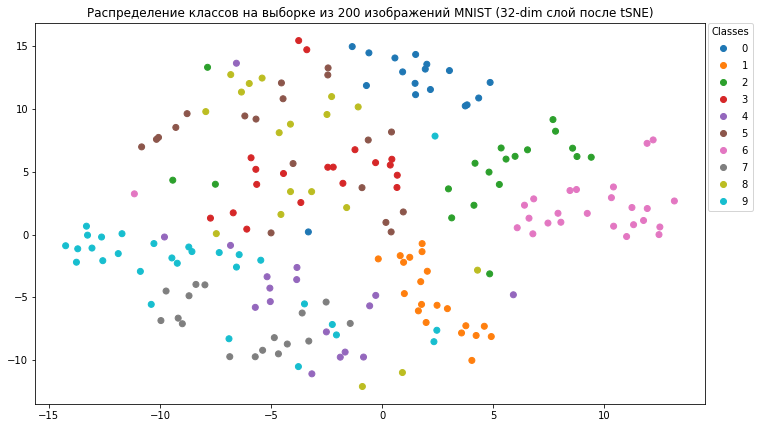

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
scatter = ax.scatter(result[:, 0], result[:, 1], c=labels.numpy(), cmap='tab10')
ax.legend(*scatter.legend_elements(), loc='upper right', title="Classes", bbox_to_anchor=(1.08, 1.015));
plt.title(f'Распределение классов на выборке из {enc.shape[0]} изображений MNIST (32-dim слой после tSNE)');

Уже лучше (по сравнению с предыдущим заданием), но всё равно хотелось бы покучнее. Но это я еще не крутил параметры tSNE.

# Convolutional autoencoder - это так, для себя побаловаться

## Preprocessing

In [3]:
mnist_data = datasets.MNIST('./MNIST_data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]
train_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## add_noise()

In [4]:
def add_noise(x, mode='crop', elementwise=False):
    # if np.random.randint(2):
    #   return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2) * 2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one

        elif mode == 'mirror':
            for i in range(x.shape[0]):
                img_part = np.random.randint(4)
                dim = np.random.choice([1,2])
                if img_part == 0:
                  x[i, :, :14, :14] = torch.flip(x[i, :, :14, :14], (0,dim))
                elif img_part == 1:
                  x[i, :, :14, 14:] = torch.flip(x[i, :, :14, 14:], (0,dim))
                elif img_part == 2:
                  x[i, :, 14:, :14] = torch.flip(x[i, :, 14:, :14], (0,dim))
                elif img_part == 3:
                  x[i, :, 14:, 14:] = torch.flip(x[i, :, 14:, 14:], (0,dim))

        elif mode == 'gaussian':
            mean = 0.5
            std = 0.5
            x = x + torch.randn(x.size()) * std + mean   

    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2) * 2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x


## Модель


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        # encoder
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 7)
        # decoder
        self.t_conv1 = nn.ConvTranspose2d(64, 32, 7)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
      # encode
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.conv3(x)
      # decode
      x = F.relu(self.t_conv1(x))
      x = F.relu(self.t_conv2(x))
      x = torch.sigmoid(self.t_conv3(x))

      return x

model = ConvAE()
model = model.to(device)
print(model)

ConvAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (t_conv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


## Обучение

### train()

In [7]:
def train(model, n_epochs=5, learning_rate=1e-3):
  torch.manual_seed(42)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  outputs = []
  for epoch in range(n_epochs):
    for data in train_loader:
      images, _ = data
      images = add_noise(images, mode='mirror', elementwise=True)
      images = images.to(device)
      optimizer.zero_grad()
      recon = model(images)
      loss = criterion(recon, images)
      loss.backward()
      optimizer.step()
           
    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, images, recon),)

  return outputs
    

In [8]:
outputs = train(model, n_epochs=20)

Epoch:1, Loss:0.0807
Epoch:2, Loss:0.0817
Epoch:3, Loss:0.0737
Epoch:4, Loss:0.0694
Epoch:5, Loss:0.0460
Epoch:6, Loss:0.0341
Epoch:7, Loss:0.0299
Epoch:8, Loss:0.0242
Epoch:9, Loss:0.0234
Epoch:10, Loss:0.0172
Epoch:11, Loss:0.0151
Epoch:12, Loss:0.0160
Epoch:13, Loss:0.0166
Epoch:14, Loss:0.0133
Epoch:15, Loss:0.0128
Epoch:16, Loss:0.0118
Epoch:17, Loss:0.0109
Epoch:18, Loss:0.0105
Epoch:19, Loss:0.0104
Epoch:20, Loss:0.0094


### Визуализация

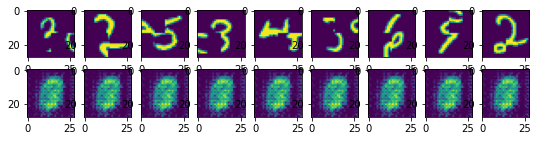

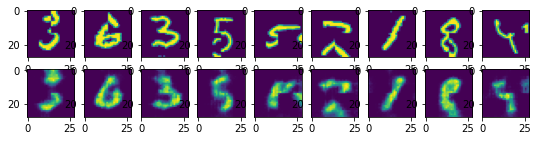

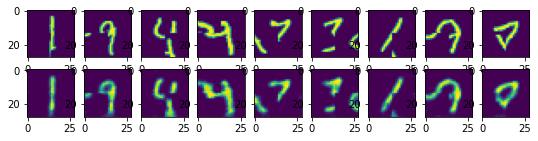

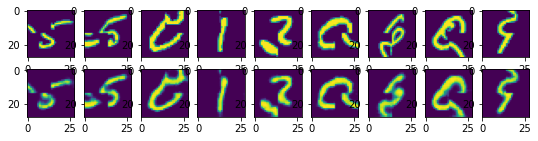

In [9]:
for k in range(0, 20, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])